Lets re-fit the KS coefficients using both the BOSS sky flux data as well as the new DESI CMX sky flux data

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import h5py
import fitsio
import numpy as np 
from astropy import units as u
from scipy.signal import medfilt, medfilt2d
from feasibgs import skymodel as Sky

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
dir_cmx = '/Users/ChangHoon/data/feasiBGS/cmx/'
dir_sky = '/Users/ChangHoon/data/feasiBGS/sky/'

In [4]:
desi_fiber_area = (1.46/2.)**2 * np.pi
boss_fiber_area = np.pi

In [5]:
def read_cmx_skies(): 
    ''' read CMX sky fibers and return median sky surface brightness measurements for each exposure
    '''
    fsky = h5py.File(os.path.join(dir_cmx, 'sky_fibers.coadd_gfa.minisv2_sv0.hdf5'), 'r')

    sky_data = {}
    for k in fsky.keys():
        sky_data[k] = fsky[k][...]
        
    bad_seeing = (sky_data['tileid'] == 70502) | (sky_data['date'] == 20200314) #bad seeing on Feb 25 and 27

    exp_cuts = ~bad_seeing

    for k in sky_data.keys(): 
        if 'wave' not in k: 
            sky_data[k] = sky_data[k][exp_cuts]
        else:
            sky_data[k] = sky_data[k]
            
    uniq_exps, i_uniq = np.unique(sky_data['expid'], return_index=True)

    # compile median observing conditions for each unique exposure and
    # get the median sky fluxes of all sky fibers
    sky_uniq_exps = {} 
    for k in ['airmass', 'moon_ill', 'moon_alt', 'moon_sep', 'exptime']: 
        sky_uniq_exps[k] = np.zeros(len(uniq_exps))

    sky_uniq_exps['wave_b'] = sky_data['wave_b']
    sky_uniq_exps['wave_r'] = sky_data['wave_r']
    sky_uniq_exps['wave_z'] = sky_data['wave_z']
    
    sky_uniq_exps['sky_b'] = np.zeros((len(uniq_exps), len(sky_data['wave_b'])))
    sky_uniq_exps['sky_r'] = np.zeros((len(uniq_exps), len(sky_data['wave_r'])))
    sky_uniq_exps['sky_z'] = np.zeros((len(uniq_exps), len(sky_data['wave_z'])))
    
    print('date \t\t tile \t exp \t texp \t airmass \t moon_ill \t moon_alt \t moon_sep')
    for _i, _i_uniq, _exp in zip(range(len(i_uniq)), i_uniq, uniq_exps): 
        _is_exp = (sky_data['expid'] == _exp)

        sky_uniq_exps['airmass'][_i] = np.median(sky_data['airmass'][_is_exp])
        sky_uniq_exps['moon_ill'][_i] = np.median(sky_data['moon_ill'][_is_exp])
        sky_uniq_exps['moon_alt'][_i] = np.median(sky_data['moon_alt'][_is_exp])
        sky_uniq_exps['moon_sep'][_i] = np.median(sky_data['moon_sep'][_is_exp])
        sky_uniq_exps['exptime'][_i] = sky_data['exptime'][_is_exp][0]
        
        sky_uniq_exps['sky_b'][_i] = np.median(sky_data['sky_b'][_is_exp], axis=0) / desi_fiber_area
        sky_uniq_exps['sky_r'][_i] = np.median(sky_data['sky_r'][_is_exp], axis=0) / desi_fiber_area
        sky_uniq_exps['sky_z'][_i] = np.median(sky_data['sky_z'][_is_exp], axis=0) / desi_fiber_area

        print('%i \t %i \t %i \t %.f \t %.2f \t\t %.2f \t\t %.1f \t\t %f' % 
              (sky_data['date'][_i_uniq], sky_data['tileid'][_i_uniq], sky_data['expid'][_i_uniq], 
               sky_uniq_exps['exptime'][_i], 
               sky_uniq_exps['airmass'][_i], sky_uniq_exps['moon_ill'][_i], 
               sky_uniq_exps['moon_alt'][_i], sky_uniq_exps['moon_sep'][_i]))

    return sky_uniq_exps

In [6]:
def read_BOSS_skies(): 
    ''' read sky fibers from BOSS
    '''
    f_boss = os.path.join(dir_sky, 'Bright_BOSS_Sky_blue.fits')
    boss = fitsio.read(f_boss)    
    f_red = os.path.join(dir_sky, 'Bright_BOSS_Sky_red.fits')
    red = fitsio.read(f_red)
    
    sky_boss = {} 
    sky_boss['airmass'] = boss['AIRMASS']
    sky_boss['moon_ill'] = boss['MOON_ILL']
    sky_boss['moon_alt'] = boss['MOON_ALT']
    sky_boss['moon_sep'] = boss['MOON_SEP']
    
    sky_boss['wave_b'] = boss['WAVE'] * 10. # convert to Angstroms
    sky_boss['sky_b'] = boss['SKY'] / boss_fiber_area
    sky_boss['wave_r'] = red['WAVE'] * 10.
    sky_boss['sky_r'] = red['SKY'] / boss_fiber_area
    return sky_boss

In [7]:
cmx_skies = read_cmx_skies()

date 		 tile 	 exp 	 texp 	 airmass 	 moon_ill 	 moon_alt 	 moon_sep
20200303 	 70500 	 52932 	 500 	 1.15 		 0.65 		 35.8 		 34.694952
20200303 	 70500 	 52934 	 500 	 1.19 		 0.65 		 31.0 		 34.560475
20200303 	 70500 	 52936 	 500 	 1.25 		 0.65 		 26.2 		 34.426285
20200303 	 70500 	 52938 	 500 	 1.31 		 0.65 		 21.6 		 34.295422
20200303 	 70500 	 52940 	 500 	 1.39 		 0.65 		 17.0 		 34.164750
20200303 	 70500 	 52942 	 500 	 1.49 		 0.66 		 12.2 		 34.028773
20200304 	 70510 	 53078 	 500 	 1.43 		 0.74 		 55.8 		 79.213270
20200304 	 70510 	 53080 	 500 	 1.34 		 0.75 		 52.1 		 79.065745
20200304 	 70510 	 53081 	 500 	 1.29 		 0.75 		 49.2 		 78.948088
20200304 	 70510 	 53082 	 500 	 1.24 		 0.75 		 46.4 		 78.831239
20200304 	 70510 	 53083 	 500 	 1.19 		 0.75 		 43.5 		 78.713989
20200304 	 70510 	 53084 	 500 	 1.16 		 0.75 		 40.7 		 78.597620
20200304 	 70510 	 53085 	 500 	 1.13 		 0.75 		 37.8 		 78.480931
20200304 	 70510 	 53086 	 500 	 1.10 		 0.75 		 34.9 		 78.

In [8]:
boss_skies = read_BOSS_skies()

[]

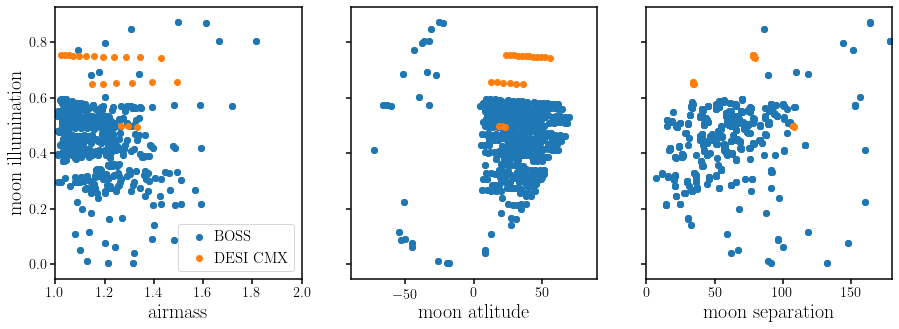

In [9]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c='C0', label='BOSS')
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], c='C1', label='DESI CMX')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c='C0')
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], c='C1')
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c='C0', label='BOSS')
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], c='C1', label='DESI CMX')
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

In [10]:
specsim_sky = Sky._specsim_initialize('desi')
specsim_wave = specsim_sky._wavelength # Ang

def sky_model_notwi(airmass, moonill, moonalt, moonsep):
    ''' sky surface brightness model (KS coefficients fit to BOSS sky fibers only; 
    see https://github.com/changhoonhahn/feasiBGS/blob/master/notebook/local_newKS_fit.ipynb) 

    :return specsim_wave, Isky:
        returns wavelength [Angstrom] and sky flux [$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]
    '''
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg

    # updated KS coefficients
    specsim_sky.moon.KS_CR = 458173.535128
    specsim_sky.moon.KS_CM0 = 5.540103
    specsim_sky.moon.KS_CM1 = 178.141045

    I_ks_rescale = specsim_sky.surface_brightness
    Isky = I_ks_rescale.value

    return specsim_wave.value[::10], Isky[::10]

Lets compare the model and data from randomly chosen exposures

Text(0.5, 0, 'Wavelength [$\\AA$]')

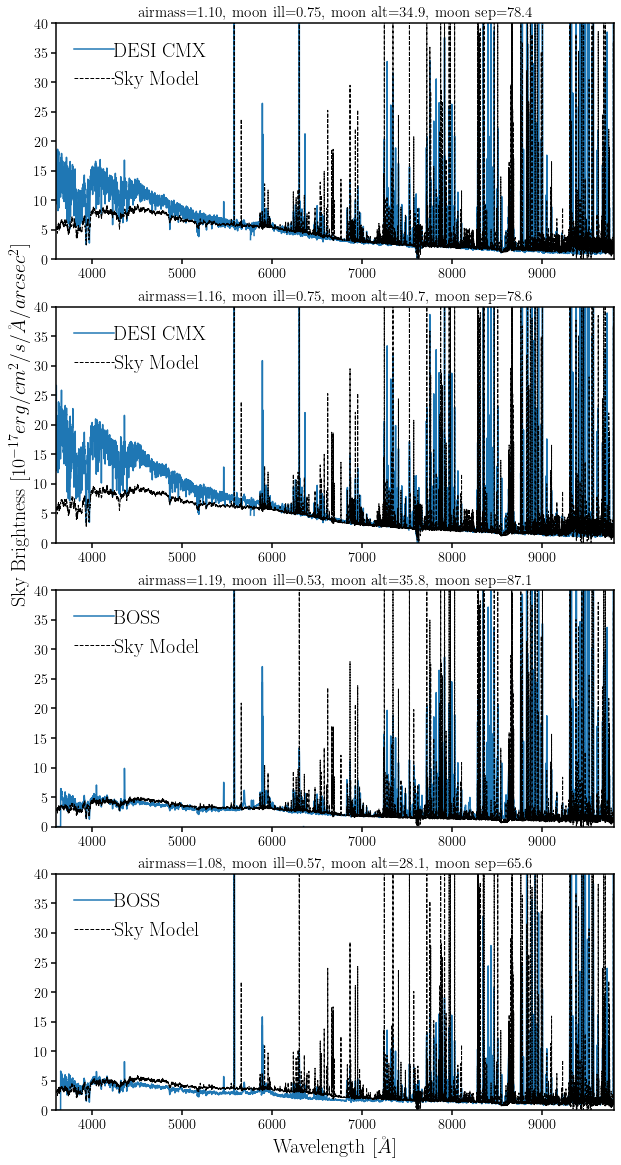

In [11]:
fig = plt.figure(figsize=(10, 20))
for i, iexp in enumerate(np.random.choice(np.arange(len(cmx_skies['airmass'])), size=2, replace=False)):
    _wave, _Isky = sky_model_notwi(cmx_skies['airmass'][iexp], cmx_skies['moon_ill'][iexp], 
                                   cmx_skies['moon_alt'][iexp], cmx_skies['moon_sep'][iexp])
    sub = fig.add_subplot(4,1,i+1)
    sub.plot(cmx_skies['wave_b'], cmx_skies['sky_b'][iexp], c='C0')
    sub.plot(cmx_skies['wave_r'], cmx_skies['sky_r'][iexp], c='C0')
    sub.plot(cmx_skies['wave_z'], cmx_skies['sky_z'][iexp], c='C0', label='DESI CMX')
    sub.plot(_wave, _Isky, c='k', ls='--', lw=1, label='Sky Model')
    sub.set_title('airmass=%.2f, moon ill=%.2f, moon alt=%.1f, moon sep=%.1f' % 
                  (cmx_skies['airmass'][iexp], cmx_skies['moon_ill'][iexp], 
                   cmx_skies['moon_alt'][iexp], cmx_skies['moon_sep'][iexp]), fontsize=15)
    sub.set_xlim(3600, 9800)
    sub.set_ylim(0., 40.)
    sub.legend(loc='upper left', fontsize=20, handletextpad=0)
sub.set_ylabel('Sky Brightness [$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]', fontsize=20)
    
for i, iexp in enumerate(np.random.choice(np.arange(len(boss_skies['airmass'])), size=2, replace=False)):
    _wave, _Isky = sky_model_notwi(boss_skies['airmass'][iexp], boss_skies['moon_ill'][iexp], 
                                   boss_skies['moon_alt'][iexp], boss_skies['moon_sep'][iexp])
    sub = fig.add_subplot(4,1,i+3)
    sub.plot(boss_skies['wave_b'][iexp], boss_skies['sky_b'][iexp], c='C0', label='BOSS')
    sub.plot(boss_skies['wave_r'][iexp], boss_skies['sky_r'][iexp], c='C0')
    sub.plot(_wave, _Isky, c='k', ls='--', lw=1, label='Sky Model')
    sub.set_title('airmass=%.2f, moon ill=%.2f, moon alt=%.1f, moon sep=%.1f' % 
                  (boss_skies['airmass'][iexp], boss_skies['moon_ill'][iexp], 
                   boss_skies['moon_alt'][iexp], boss_skies['moon_sep'][iexp]), fontsize=15)
    sub.legend(loc='upper left', fontsize=20, handletextpad=0)
    sub.set_xlim(3600, 9800)
    sub.set_ylim(0., 40.)
sub.set_xlabel("Wavelength [$\AA$]", fontsize=20)

In [12]:
def get_continuum(flux, data_set='desi'):
    if data_set == 'desi': 
        cont = medfilt(flux, 151) 
    elif data_set == 'boss': 
        cont = medfilt(flux[::10], 121)
    return cont

def get_sky_at_wavelength(wave, sky, wavelength=4500, data_set='desi'): 
    ''' given wavelength and surface brightness, return the value of the 
    continuum at ~4500A
    '''
    if data_set == 'boss': wave = wave[::10]
    near_wave = (wave > wavelength-5.) & (wave < wavelength+5.)
    assert np.sum(near_wave) > 0
    
    sky_cont = get_continuum(sky, data_set=data_set)
    return np.median(sky_cont[near_wave])

def _get_model_at_wavelength(wave, sky, wavelength=4500): 
    ''' given wavelength and sky model surface brightness, return the value of the 
    continuum at ~4500A
    '''
    wlim = (wave > 4000.) & (wave < 6000.)
    sky_cont = medfilt(sky[wlim], 121)

    near_wave = (wave[wlim] > wavelength-5.) & (wave[wlim] < wavelength+5.)
    return np.median(sky_cont[near_wave])


def get_model_at_wavelength(airmass, moon_ill, moon_alt, moon_sep, wavelength=4500): 
    
    airmasses = np.atleast_1d(airmass)
    moon_ills = np.atleast_1d(moon_ill)
    moon_alts = np.atleast_1d(moon_alt)
    moon_seps = np.atleast_1d(moon_sep)
    
    Iskys = [] 
    for _airmass, _ill, _alt, _sep in zip(airmasses, moon_ills, moon_alts, moon_seps): 
        wave, _Isky = sky_model_notwi(_airmass, _ill, _alt, _sep) 
        Iskys.append(_Isky)
        
    wlim = (wave > 4000.) & (wave < 6000.)
    sky_cont = medfilt2d(np.array(Iskys)[:,wlim], (1, 121))
    
    near_wave = (wave[wlim] > wavelength-5.) & (wave[wlim] < wavelength+5.)
    return np.median(sky_cont[:,near_wave], axis=1)

In [13]:
desi_4500 = np.zeros(len(cmx_skies['airmass']))
desi_5500 = np.zeros(len(cmx_skies['airmass']))
for i in range(len(cmx_skies['airmass'])): 
    desi_4500[i] = get_sky_at_wavelength(cmx_skies['wave_b'], cmx_skies['sky_b'][i], wavelength=4500, data_set='desi')
    desi_5500[i] = get_sky_at_wavelength(cmx_skies['wave_b'], cmx_skies['sky_b'][i], wavelength=5500, data_set='desi')

In [14]:
boss_4500 = np.zeros(len(boss_skies['airmass']))
boss_5500 = np.zeros(len(boss_skies['airmass']))
for i in range(len(boss_skies['airmass'])): 
    boss_4500[i] = get_sky_at_wavelength(boss_skies['wave_b'][i], boss_skies['sky_b'][i], wavelength=4500, data_set='boss')
    boss_5500[i] = get_sky_at_wavelength(boss_skies['wave_b'][i], boss_skies['sky_b'][i], wavelength=5500, data_set='boss')

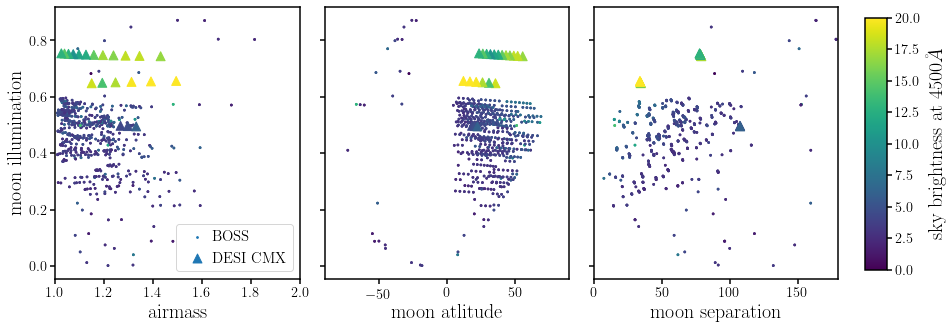

In [15]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c=boss_4500, s=3, vmin=0., vmax=20., label='BOSS')
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], marker='^', c=desi_4500, s=80, vmin=0., vmax=20., label='DESI CMX')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c=boss_4500, s=3, vmin=0., vmax=20.)
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], marker='^', s=80, c=desi_4500, vmin=0., vmax=20.)
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sct = sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c=boss_4500, s=3, vmin=0., vmax=20.)
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], marker='^', c=desi_4500, s=80, vmin=0., vmax=20.)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label(label='sky brightness at $4500\AA$', fontsize=20)

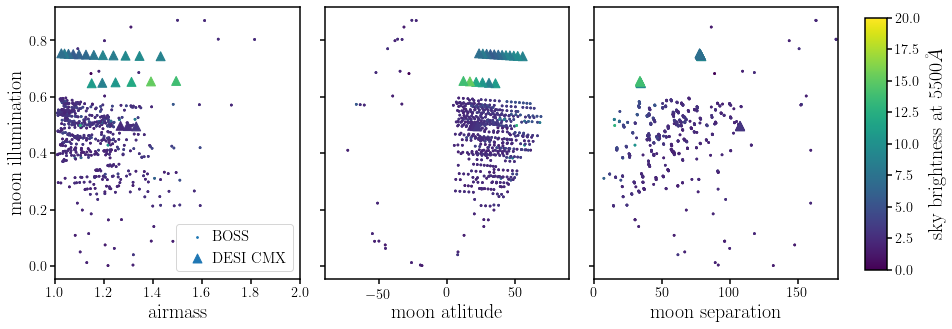

In [16]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c=boss_5500, s=3, vmin=0., vmax=20., label='BOSS')
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], marker='^', c=desi_5500, s=80, vmin=0., vmax=20., label='DESI CMX')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c=boss_5500, s=3, vmin=0., vmax=20.)
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], marker='^', c=desi_5500, s=80, vmin=0., vmax=20.)
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sct = sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c=boss_5500, s=3, vmin=0., vmax=20.)
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], marker='^', c=desi_5500, s=80, vmin=0., vmax=20.)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label(label='sky brightness at $5500\AA$', fontsize=20)

At least by eye the sky brightnesses of DESI CMX and BOSS seem reasonably in agreement. At high `MOON_ILL`, BOSS only has exposures with large `MOON_SEP` so they don't overlap in parameter space. 

In [17]:
model_desi_4500 = get_model_at_wavelength(cmx_skies['airmass'], 
                                          cmx_skies['moon_ill'], 
                                          cmx_skies['moon_alt'], 
                                          cmx_skies['moon_sep'], 
                                          wavelength=4500)
model_desi_5500 = get_model_at_wavelength(cmx_skies['airmass'], 
                                          cmx_skies['moon_ill'], 
                                          cmx_skies['moon_alt'], 
                                          cmx_skies['moon_sep'], 
                                          wavelength=5500)

In [18]:
model_boss_4500 = get_model_at_wavelength(boss_skies['airmass'], 
                                         boss_skies['moon_ill'],
                                         boss_skies['moon_alt'],
                                         boss_skies['moon_sep'], 
                                         wavelength=4500)
model_boss_5500 = get_model_at_wavelength(boss_skies['airmass'], 
                                         boss_skies['moon_ill'],
                                         boss_skies['moon_alt'],
                                         boss_skies['moon_sep'], 
                                         wavelength=5500)

In [19]:
desi_4500/model_desi_4500

array([1.90818227, 1.47291632, 1.83784059, 2.12147357, 2.74566224,
       2.56162238, 1.54156673, 1.7413166 , 1.80772603, 1.68378591,
       1.83561721, 1.67110077, 1.40873161, 1.39777225, 1.2537363 ,
       1.60970366, 1.93339249, 1.75307469, 1.15619797, 1.2161383 ,
       1.51713559])

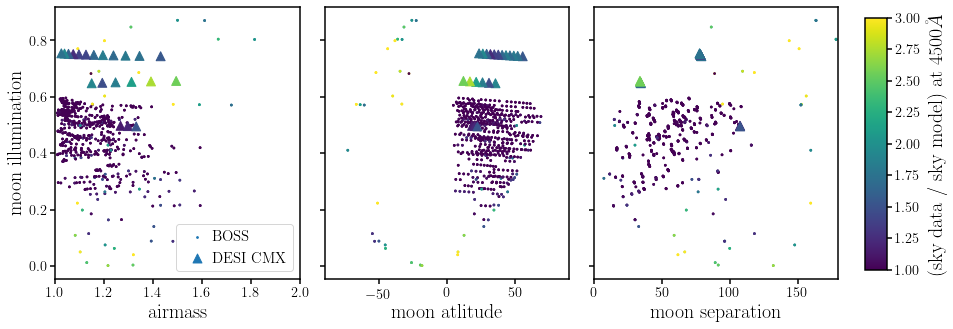

In [20]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c=boss_4500/model_boss_4500, s=3, vmin=1., vmax=3., label='BOSS')
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], marker='^', c=desi_4500/model_desi_4500, s=80, vmin=1., vmax=3., label='DESI CMX')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c=boss_4500/model_boss_4500, s=3, vmin=1., vmax=3.)
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], marker='^', s=80, c=desi_4500/model_desi_4500, vmin=1., vmax=3.)
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sct = sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c=boss_4500/model_boss_4500, s=3, vmin=1., vmax=3.)
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], marker='^', c=desi_4500/model_desi_4500, s=80, vmin=1., vmax=3.)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label(label='(sky data / sky model) at $4500\AA$', fontsize=20)

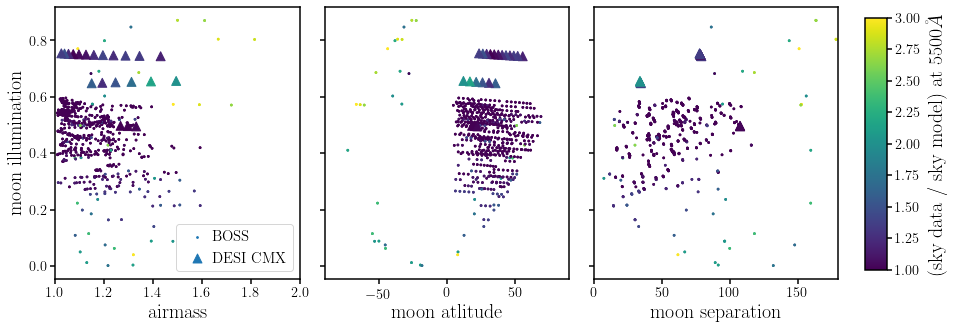

In [21]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c=boss_5500/model_boss_5500, s=3, vmin=1., vmax=3., label='BOSS')
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], marker='^', c=desi_5500/model_desi_5500, s=80, vmin=1., vmax=3., label='DESI CMX')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c=boss_5500/model_boss_5500, s=3, vmin=1., vmax=3.)
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], marker='^', s=80, c=desi_5500/model_desi_5500, vmin=1., vmax=3.)
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sct = sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c=boss_5500/model_boss_5500, s=3, vmin=1., vmax=3.)
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], marker='^', c=desi_5500/model_desi_5500, s=80, vmin=1., vmax=3.)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label(label='(sky data / sky model) at $5500\AA$', fontsize=20)

Now lets fit the coefficients for the sky model that minimizes the discrepancy with BOSS and DESI CMX data

In [31]:
def sky_model_free(cr, cm0, cm1, m0, m1, m2, airmass, moonill, moonalt, moonsep):
    ''' sky surface brightness model (KS coefficients fit to BOSS sky fibers only; 
    see https://github.com/changhoonhahn/feasiBGS/blob/master/notebook/local_newKS_fit.ipynb) 

    :return specsim_wave, Isky:
        returns wavelength [Angstrom] and sky flux [$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]
    '''
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg

    # updated KS coefficients
    specsim_sky.moon.KS_CR = cr
    specsim_sky.moon.KS_CM0 = cm0
    specsim_sky.moon.KS_CM1 = cm1
    
    specsim_sky.moon.KS_M0 = m0
    specsim_sky.moon.KS_M1 = m1
    specsim_sky.moon.KS_M2 = m2

    I_ks_rescale = specsim_sky.surface_brightness
    Isky = I_ks_rescale.value

    return specsim_wave.value, Isky


def get_freemodel_at_wavelength(cr, cm0, cm1, m0, m1, m2, airmass, moon_ill, moon_alt, moon_sep, wavelength=4500): 
    
    airmasses = np.atleast_1d(airmass)
    moon_ills = np.atleast_1d(moon_ill)
    moon_alts = np.atleast_1d(moon_alt)
    moon_seps = np.atleast_1d(moon_sep)
    
    Iskys = [] 
    for _airmass, _ill, _alt, _sep in zip(airmasses, moon_ills, moon_alts, moon_seps): 
        wave, _Isky = sky_model_free(cr, cm0, cm1, m0, m1, m2, _airmass, _ill, _alt, _sep) 
        Iskys.append(_Isky)
        
    wlim = (wave > 4000.) & (wave < 6000.)
    sky_cont = medfilt2d(np.array(Iskys)[:,wlim], (1, 121))
    
    near_wave = (wave[wlim] > wavelength-5.) & (wave[wlim] < wavelength+5.)
    return np.median(sky_cont[:,near_wave], axis=1)


def L2(theta): 
    ''' simple L2 objective function
    '''
    cr, cm0, cm1, m0, m1, m2 = theta
    
    _L2 = 0
    
    _model_4500 = get_freemodel_at_wavelength(cr, cm0, cm1, m0, m1, m2, 
                                              cmx_skies['airmass'], 
                                              cmx_skies['moon_ill'], 
                                              cmx_skies['moon_alt'], 
                                              cmx_skies['moon_sep'], 
                                             wavelength=4500)
    _model_5500 = get_freemodel_at_wavelength(cr, cm0, cm1, m0, m1, m2, 
                                              cmx_skies['airmass'], 
                                              cmx_skies['moon_ill'], 
                                              cmx_skies['moon_alt'], 
                                              cmx_skies['moon_sep'], 
                                             wavelength=5500)    
    _L2 += np.sum((desi_4500 - _model_4500)**2) + np.sum((desi_5500 - _model_5500)**2)
    
    _model_4500 = get_freemodel_at_wavelength(cr, cm0, cm1, m0, m1, m2, 
                                              boss_skies['airmass'][::10], 
                                              boss_skies['moon_ill'][::10], 
                                              boss_skies['moon_alt'][::10], 
                                              boss_skies['moon_sep'][::10], 
                                             wavelength=4500)
    _model_5500 = get_freemodel_at_wavelength(cr, cm0, cm1, m0, m1, m2, 
                                              boss_skies['airmass'][::10], 
                                              boss_skies['moon_ill'][::10], 
                                              boss_skies['moon_alt'][::10], 
                                              boss_skies['moon_sep'][::10], 
                                             wavelength=5500)    
    _L2 += np.sum((boss_4500[::10] - _model_4500)**2) + np.sum((boss_5500[::10] - _model_5500)**2)    
    print(theta, _L2)
    return _L2

In [28]:
import scipy.optimize as sciop

In [32]:
t0 = np.array([458173.535128, 5.540103, 178.141045, -12.73, 0.026, 4.])

In [40]:
theta_min = sciop.minimize(L2, t0, method='Nelder-Mead')

[ 4.58173535e+05  5.54010300e+00  1.78141045e+02 -1.27300000e+01
  2.60000000e-02  4.00000000e+00] 1455.0679103554644
[ 4.81082212e+05  5.54010300e+00  1.78141045e+02 -1.27300000e+01
  2.60000000e-02  4.00000000e+00] 1397.1487100917357
[ 4.58173535e+05  5.81710815e+00  1.78141045e+02 -1.27300000e+01
  2.60000000e-02  4.00000000e+00] 1292.0221825709962
[ 4.58173535e+05  5.54010300e+00  1.87048097e+02 -1.27300000e+01
  2.60000000e-02  4.00000000e+00] 1443.0667687692276
[ 4.58173535e+05  5.54010300e+00  1.78141045e+02 -1.33665000e+01
  2.60000000e-02  4.00000000e+00] 1455.0679103554644
[ 4.58173535e+05  5.54010300e+00  1.78141045e+02 -1.27300000e+01
  2.73000000e-02  4.00000000e+00] 1455.0679103554644
[ 4.58173535e+05  5.54010300e+00  1.78141045e+02 -1.27300000e+01
  2.60000000e-02  4.20000000e+00] 1455.0679103554644
[ 4.65809761e+05  5.63243805e+00  1.81110062e+02 -1.29421667e+01
  2.64333333e-02  3.80000000e+00] 1366.3263153333105
[ 4.68355169e+05  5.66321640e+00  1.82099735e+02 -1.3012

[ 5.05046865e+05  5.73045498e+00  1.92946224e+02 -1.24677760e+01
  2.54065237e-02  3.68200699e+00] 1285.9014506765886
[ 5.13600935e+05  5.71388230e+00  1.96527893e+02 -1.24051495e+01
  2.54104028e-02  3.61657761e+00] 1285.5844598250205
[ 5.05539372e+05  5.71365860e+00  1.95280990e+02 -1.23436516e+01
  2.55180033e-02  3.68094458e+00] 1285.4735450995465
[ 5.11316608e+05  5.68860385e+00  1.99562453e+02 -1.21959013e+01
  2.56179724e-02  3.63912160e+00] 1285.0113112468812
[ 5.14983354e+05  5.68717430e+00  1.98311938e+02 -1.23326148e+01
  2.54486777e-02  3.61289394e+00] 1284.870030907212
[ 5.26857612e+05  5.64834132e+00  2.03639932e+02 -1.22306136e+01
  2.54504985e-02  3.52721026e+00] 1284.134440918666
[ 5.21017576e+05  5.69302265e+00  2.00247817e+02 -1.23125713e+01
  2.55253398e-02  3.58257612e+00] 1285.0412278875924
[ 5.30865903e+05  5.64191284e+00  2.04987507e+02 -1.20643282e+01
  2.56422243e-02  3.50145314e+00] 1283.8067569181585
[ 5.49009205e+05  5.58282678e+00  2.12902654e+02 -1.178614

[ 6.05999976e+05  5.33987321e+00  2.55455402e+02 -1.09016488e+01
  2.68982241e-02  2.90401125e+00] 1281.0567585655158
[ 6.34833571e+05  5.17208050e+00  2.83184297e+02 -1.02210655e+01
  2.77961587e-02  2.65826346e+00] 1280.8472373876634
[ 6.26628404e+05  5.20124825e+00  2.81221364e+02 -1.03053778e+01
  2.79943634e-02  2.70768279e+00] 1280.8610613843778
[ 6.31448229e+05  5.16369147e+00  2.87092949e+02 -1.01482723e+01
  2.81830841e-02  2.66720153e+00] 1280.8837873877737
[ 6.38996484e+05  5.12694081e+00  2.93910605e+02 -1.00226742e+01
  2.84172737e-02  2.60345413e+00] 1280.773504819996
[ 6.48780460e+05  5.06089751e+00  3.06662527e+02 -9.75546586e+00
  2.89698635e-02  2.51087463e+00] 1280.8112927281525
[ 6.44571523e+05  5.09501042e+00  2.98173623e+02 -9.84217869e+00
  2.85834942e-02  2.55916241e+00] 1280.8111793303833
[ 6.37636964e+05  5.15837884e+00  2.86359692e+02 -1.01507335e+01
  2.79976038e-02  2.63149003e+00] 1280.8799885299345
[ 6.36089780e+05  5.15970700e+00  2.86543006e+02 -1.01501

[ 6.43679263e+05  5.02778573e+00  4.07629499e+02 -9.65518606e+00
  3.47246544e-02  2.21015289e+00] 1280.1757880077957
[ 6.33531724e+05  5.12065301e+00  4.21337790e+02 -1.01631139e+01
  3.54476257e-02  2.21856215e+00] 1279.8745549904816
[ 6.26782588e+05  5.16648868e+00  4.29902535e+02 -1.03677040e+01
  3.59679907e-02  2.22533974e+00] 1279.7987429594803
[ 6.21522709e+05  5.22866748e+00  4.07924470e+02 -1.06869181e+01
  3.47125700e-02  2.32367057e+00] 1280.5314859046898
[ 6.38140124e+05  5.07800617e+00  4.07703242e+02 -9.91311907e+00
  3.47216333e-02  2.23853231e+00] 1280.0061381602386
[ 6.24766149e+05  5.17437558e+00  4.30529400e+02 -1.05131302e+01
  3.59115295e-02  2.23404197e+00] 1279.7247173525966
[ 6.17218274e+05  5.22103349e+00  4.50446982e+02 -1.08446902e+01
  3.69549544e-02  2.20882836e+00] 1279.78310059215
[ 6.22029931e+05  5.20955231e+00  4.21129115e+02 -1.06500251e+01
  3.54112077e-02  2.27848207e+00] 1280.0612808262886
[ 6.34112576e+05  5.11089270e+00  4.11059710e+02 -1.009734

[ 5.84060691e+05  5.29662867e+00  6.81930089e+02 -1.16794489e+01
  5.04793540e-02  1.62911058e+00] 1278.8313732449135
[ 5.85942290e+05  5.28228244e+00  6.79726912e+02 -1.15915400e+01
  5.03523912e-02  1.62689333e+00] 1278.8026212820002
[ 5.83655162e+05  5.28479821e+00  7.16049658e+02 -1.16661333e+01
  5.23914532e-02  1.52096945e+00] 1278.8112751404476
[ 5.84420580e+05  5.28549084e+00  7.00433854e+02 -1.16444874e+01
  5.15152339e-02  1.56758830e+00] 1278.8022533901644
[ 5.78212025e+05  5.30798629e+00  7.25850894e+02 -1.18263644e+01
  5.30260578e-02  1.51761488e+00] 1278.8319140997373
[ 5.87221850e+05  5.27924022e+00  6.74923249e+02 -1.15632991e+01
  5.00573548e-02  1.63565121e+00] 1278.800814412154
[ 5.87612610e+05  5.27497405e+00  6.90509215e+02 -1.15436303e+01
  5.09143114e-02  1.58315449e+00] 1278.7978068202642
[ 5.90206981e+05  5.26405463e+00  6.91415024e+02 -1.14606538e+01
  5.09219727e-02  1.56672894e+00] 1278.8001285163023
[ 5.88283960e+05  5.27085522e+00  6.87782953e+02 -1.15026

[ 6.04399514e+05  5.17325320e+00  1.13700093e+03 -1.11363396e+01
  7.50391869e-02  5.18334389e-02] 1278.7270510227681
[ 6.08002035e+05  5.15469109e+00  1.16574911e+03 -1.10070004e+01
  7.65888635e-02 -6.02867240e-02] 1278.7253098590813
[ 6.10689350e+05  5.13809237e+00  1.23599432e+03 -1.09277396e+01
  8.04087889e-02 -3.01879046e-01] 1278.7242679642213
[ 6.11701948e+05  5.13443778e+00  1.21447383e+03 -1.09020487e+01
  7.91969644e-02 -2.37364190e-01] 1278.729103430639
[ 6.04935154e+05  5.16689040e+00  1.20362821e+03 -1.11368407e+01
  7.86928948e-02 -1.67599327e-01] 1278.7228528436149
[ 6.02701957e+05  5.17421457e+00  1.25904133e+03 -1.12362557e+01
  8.17539902e-02 -3.36008559e-01] 1278.727923210743
[ 6.10141624e+05  5.13881252e+00  1.29528250e+03 -1.09918238e+01
  8.35883867e-02 -4.90206876e-01] 1278.716877849302
[ 6.13022388e+05  5.11973750e+00  1.41703985e+03 -1.09394951e+01
  9.01677636e-02 -8.98795406e-01] 1278.714859450442
[ 6.11068032e+05  5.13145771e+00  1.35641018e+03 -1.09813885

[ 6.15872052e+05  5.09107600e+00  2.10668422e+03 -1.12292490e+01
  1.27215044e-01 -3.13716645e+00] 1278.687776099623
[ 6.16914205e+05  5.08153153e+00  2.27371445e+03 -1.12831243e+01
  1.36223766e-01 -3.68181535e+00] 1278.692702624398
[ 6.16284523e+05  5.09008480e+00  2.13868416e+03 -1.12327195e+01
  1.28860974e-01 -3.24129750e+00] 1278.6837003757755
[ 6.17427050e+05  5.08205916e+00  2.29195678e+03 -1.12761626e+01
  1.37057705e-01 -3.74089885e+00] 1278.6815288881467
[ 6.15605289e+05  5.09419126e+00  2.13553622e+03 -1.12714628e+01
  1.28663297e-01 -3.22679510e+00] 1278.682457168074
[ 6.18752839e+05  5.07433930e+00  2.29171576e+03 -1.12301187e+01
  1.37075399e-01 -3.74758939e+00] 1278.686222682518
[ 6.16855876e+05  5.08451925e+00  2.29779171e+03 -1.13148473e+01
  1.37366709e-01 -3.75670467e+00] 1278.6815104209095
[ 6.17328973e+05  5.07959849e+00  2.45793652e+03 -1.13961947e+01
  1.45926416e-01 -4.27495500e+00] 1278.6803629651602
[ 6.15629236e+05  5.08646087e+00  2.41984202e+03 -1.14238433

[ 6.22005784e+05  5.04018424e+00  7.62504234e+03 -1.45482327e+01
  4.20204175e-01 -2.09011892e+01] 1278.647109938217
[ 6.21058457e+05  5.04905969e+00  6.33276994e+03 -1.37581711e+01
  3.51602567e-01 -1.67442869e+01] 1278.6496752187056
[ 6.22037706e+05  5.04308270e+00  6.82868011e+03 -1.40331482e+01
  3.77903864e-01 -1.83423169e+01] 1278.6486976141737
[ 6.21519042e+05  5.04187923e+00  7.60834107e+03 -1.45605234e+01
  4.19325462e-01 -2.08445729e+01] 1278.648131469674
[ 6.20229796e+05  5.04900131e+00  7.88603489e+03 -1.47928890e+01
  4.34013551e-01 -2.17292328e+01] 1278.647578442291
[ 6.23062674e+05  5.03449217e+00  8.25501387e+03 -1.49212803e+01
  4.53619207e-01 -2.29299795e+01] 1278.6464495978344
[ 6.24765798e+05  5.02457842e+00  9.28890744e+03 -1.55230865e+01
  5.08482248e-01 -2.62601808e+01] 1278.6482676617004
[ 6.21997977e+05  5.04267146e+00  7.79944061e+03 -1.46475348e+01
  4.29402231e-01 -2.14601223e+01] 1278.6471320061896
[ 6.22559202e+05  5.03471068e+00  9.00141436e+03 -1.5409698

[ 6.24615137e+05  5.01970647e+00  4.52056726e+04 -3.86452599e+01
  2.41271714e+00 -1.41610635e+02] 1278.6361578071933
[ 6.22633955e+05  5.03123286e+00  3.27234929e+04 -3.06743250e+01
  1.75092272e+00 -1.01510694e+02] 1278.6362782189203
[ 6.24003614e+05  5.02291484e+00  4.19216747e+04 -3.65357078e+01
  2.23861509e+00 -1.31060056e+02] 1278.635925716207
[ 6.24506001e+05  5.01944898e+00  4.91467204e+04 -4.11668704e+01
  2.62168240e+00 -1.54267115e+02] 1278.6363642301794
[ 6.24086606e+05  5.02339233e+00  4.03478247e+04 -3.55293873e+01
  2.15515990e+00 -1.26005479e+02] 1278.6357907559723
[ 6.24536013e+05  5.02121074e+00  4.43894902e+04 -3.81222288e+01
  2.36943710e+00 -1.38988018e+02] 1278.6360087103665
[ 6.24456903e+05  5.01984132e+00  4.62250961e+04 -3.93027946e+01
  2.46677971e+00 -1.44883248e+02] 1278.6364245171467
[ 6.23465305e+05  5.02695632e+00  3.39643035e+04 -3.14332508e+01
  1.81671687e+00 -1.05500821e+02] 1278.6359994323302
[ 6.23028693e+05  5.02847681e+00  4.00257597e+04 -3.53577

[ 6.23863463e+05  5.02363176e+00  2.42071735e+05 -1.65833505e+02
  1.28497328e+01 -7.73854262e+02] 1278.6334258537918
[ 6.23653639e+05  5.02419323e+00  2.87940659e+05 -1.95459684e+02
  1.52815172e+01 -9.21164250e+02] 1278.6333083381128
[ 6.23595082e+05  5.02419131e+00  3.37934158e+05 -2.27745613e+02
  1.79319687e+01 -1.08172146e+03] 1278.6333316689438
[ 6.24249380e+05  5.02125025e+00  3.19450447e+05 -2.15805831e+02
  1.69520400e+01 -1.02236350e+03] 1278.633437214352
[ 6.23836819e+05  5.02400778e+00  3.00392297e+05 -2.03510669e+02
  1.59416392e+01 -9.61153788e+02] 1278.633436001788
[ 6.23292686e+05  5.02672363e+00  2.10733910e+05 -1.45607666e+02
  1.11883204e+01 -6.73206957e+02] 1278.633514459603
[ 6.24010207e+05  5.02261860e+00  2.92271312e+05 -1.98256290e+02
  1.55111101e+01 -9.35074367e+02] 1278.6333610708123
[ 6.23763043e+05  5.02350304e+00  2.27085065e+05 -1.56151368e+02
  1.20552115e+01 -7.25723532e+02] 1278.6334483658545
[ 6.23818375e+05  5.02388160e+00  2.82065489e+05 -1.9167084

[ 6.23740740e+05  5.02359312e+00  3.98105288e+06 -2.58140533e+03
  2.11074606e+02 -1.27818202e+04] 1278.6329687375792
[ 6.23801162e+05  5.02321795e+00  5.12592808e+06 -3.32105450e+03
  2.71771019e+02 -1.64586570e+04] 1278.6329728332491
[ 6.23883012e+05  5.02279848e+00  4.02267849e+06 -2.60829599e+03
  2.13281419e+02 -1.29155041e+04] 1278.632988065715
[ 6.23950786e+05  5.02259901e+00  3.74002032e+06 -2.42568284e+03
  1.98296086e+02 -1.20077307e+04] 1278.6329953719073
[ 6.23670802e+05  5.02395959e+00  3.10404551e+06 -2.01481311e+03
  1.64579406e+02 -9.96525709e+03] 1278.6329766277156
[ 6.23574512e+05  5.02460068e+00  2.30318475e+06 -1.49741576e+03
  1.22121175e+02 -7.39324344e+03] 1278.6329871720545
[ 6.23651637e+05  5.02415013e+00  2.73305818e+06 -1.77513582e+03
  1.44911236e+02 -8.77380861e+03] 1278.6329752689185
[ 6.23648958e+05  5.02413449e+00  3.99173384e+06 -2.58830343e+03
  2.11640856e+02 -1.28161224e+04] 1278.632964775765
[ 6.23588770e+05  5.02445872e+00  4.77066995e+06 -3.091535

[ 6.23662818e+05  5.02416469e+00  3.12418166e+07 -2.01932652e+04
  1.65632420e+03 -1.00331426e+05] 1278.632940145026
[ 6.23707524e+05  5.02392562e+00  3.47000982e+07 -2.24274936e+04
  1.83966756e+03 -1.11437909e+05] 1278.6329392808293
[ 6.23694941e+05  5.02394373e+00  4.27543059e+07 -2.76309341e+04
  2.26666735e+03 -1.37304489e+05] 1278.6329380700076
[ 6.23698244e+05  5.02391306e+00  5.25226560e+07 -3.39417965e+04
  2.78454368e+03 -1.68676141e+05] 1278.6329377588402
[ 6.23732266e+05  5.02370024e+00  4.18237082e+07 -2.70297221e+04
  2.21733102e+03 -1.34315818e+05] 1278.6329396727645
[ 6.23714904e+05  5.02381635e+00  3.91782353e+07 -2.53206079e+04
  2.07707932e+03 -1.25819720e+05] 1278.6329387083615
[ 6.23693508e+05  5.02398312e+00  4.75793100e+07 -3.07481325e+04
  2.52246851e+03 -1.52800284e+05] 1278.6329380211596
[ 6.23652063e+05  5.02418919e+00  4.86225875e+07 -3.14221318e+04
  2.57777864e+03 -1.56150833e+05] 1278.6329388164556
[ 6.23702688e+05  5.02388715e+00  5.56745543e+07 -3.59780

[ 6.23713552e+05  5.02385564e+00  2.65649147e+08 -1.71632576e+05
  1.40836026e+04 -8.53144873e+05] 1278.6329361417434
[ 6.23694703e+05  5.02395676e+00  2.99896723e+08 -1.93758284e+05
  1.58992632e+04 -9.63133051e+05] 1278.6329359944614
[ 6.23693851e+05  5.02396406e+00  3.63351680e+08 -2.34753479e+05
  1.92633748e+04 -1.16692252e+06] 1278.6329359514684
[ 6.23707746e+05  5.02387354e+00  2.70119080e+08 -1.74520389e+05
  1.43205794e+04 -8.67500334e+05] 1278.6329360844377
[ 6.23710698e+05  5.02387715e+00  2.74305971e+08 -1.77225334e+05
  1.45425505e+04 -8.80946790e+05] 1278.632936129431
[ 6.23694584e+05  5.02394919e+00  2.53506277e+08 -1.63787649e+05
  1.34398394e+04 -8.14147305e+05] 1278.6329360529546
[ 6.23697763e+05  5.02392624e+00  2.96847246e+08 -1.91788165e+05
  1.57375930e+04 -9.53339471e+05] 1278.6329360147724
[ 6.23701859e+05  5.02391526e+00  3.29474642e+08 -2.12867157e+05
  1.74673586e+04 -1.05812434e+06] 1278.6329359539595
[ 6.23702520e+05  5.02390472e+00  3.56679904e+08 -2.30443

[ 6.23698401e+05  5.02393828e+00  2.90149347e+09 -1.87452485e+06
  1.53824844e+05 -9.31831975e+06] 1278.632935686714
[ 6.23697229e+05  5.02393564e+00  2.88554113e+09 -1.86421881e+06
  1.52979119e+05 -9.26708784e+06] 1278.6329356744882
[ 6.23701664e+05  5.02391514e+00  3.05564153e+09 -1.97411250e+06
  1.61997118e+05 -9.81337566e+06] 1278.6329356739757
[ 6.23702317e+05  5.02391480e+00  3.27487565e+09 -2.11574912e+06
  1.73619977e+05 -1.05174594e+07] 1278.6329356796507
[ 6.23701524e+05  5.02391430e+00  3.78019557e+09 -2.44221203e+06
  2.00409887e+05 -1.21403251e+07] 1278.6329356671351
[ 6.23696961e+05  5.02393588e+00  3.11894483e+09 -2.01500972e+06
  1.65353189e+05 -1.00166781e+07] 1278.6329356750905
[ 6.23696780e+05  5.02393791e+00  3.95298275e+09 -2.55384152e+06
  2.09570328e+05 -1.26952417e+07] 1278.6329356658393
[ 6.23700872e+05  5.02392126e+00  3.72241506e+09 -2.40488282e+06
  1.97346611e+05 -1.19547595e+07] 1278.6329356683607
[ 6.23701819e+05  5.02391670e+00  4.23477675e+09 -2.73589

[ 6.23698961e+05  5.02392917e+00  6.87763789e+10 -4.44331209e+07
  3.64623074e+06 -2.20879534e+08] 1278.6329356371139
[ 6.23699255e+05  5.02392616e+00  6.64585992e+10 -4.29357149e+07
  3.52335193e+06 -2.13435843e+08] 1278.6329356377396
[ 6.23698525e+05  5.02393026e+00  6.90774650e+10 -4.46276382e+07
  3.66219304e+06 -2.21846490e+08] 1278.6329356373399
[ 6.23699568e+05  5.02392607e+00  6.93451604e+10 -4.48005833e+07
  3.67638511e+06 -2.22706210e+08] 1278.6329356375481
[ 6.23698082e+05  5.02393330e+00  6.87898988e+10 -4.44418555e+07
  3.64694750e+06 -2.20922954e+08] 1278.6329356371753
[ 6.23698734e+05  5.02392906e+00  8.69642989e+10 -5.61834615e+07
  4.61047680e+06 -2.79291149e+08] 1278.6329356370904
[ 6.23698640e+05  5.02392891e+00  1.08816063e+11 -7.03008357e+07
  5.76896428e+06 -3.49469423e+08] 1278.6329356375152
[ 6.23699134e+05  5.02392765e+00  9.49095616e+10 -6.13165137e+07
  5.03170079e+06 -3.04807845e+08] 1278.6329356367676
[ 6.23699413e+05  5.02392629e+00  1.18250490e+11 -7.6395

[ 6.23698765e+05  5.02392961e+00  6.57684319e+11 -4.24898225e+08
  3.48676218e+07 -2.11219332e+09] 1278.6329356357246
[ 6.23698625e+05  5.02393081e+00  7.42171700e+11 -4.79481460e+08
  3.93467830e+07 -2.38352970e+09] 1278.6329356356691
[ 6.23698555e+05  5.02393136e+00  8.81665294e+11 -5.69601564e+08
  4.67421393e+07 -2.83152189e+09] 1278.6329356356823
[ 6.23698733e+05  5.02392997e+00  8.54651006e+11 -5.52148931e+08
  4.53099568e+07 -2.74476385e+09] 1278.6329356356493
[ 6.23698775e+05  5.02392965e+00  1.05769059e+12 -6.83323046e+08
  5.60742511e+07 -3.39683788e+09] 1278.6329356356453
[ 6.23698662e+05  5.02392994e+00  7.75764266e+11 -5.01184001e+08
  4.11277178e+07 -2.49141427e+09] 1278.63293563575
[ 6.23698716e+05  5.02393029e+00  6.88953498e+11 -4.45099738e+08
  3.65253806e+07 -2.21261619e+09] 1278.6329356356828
[ 6.23698615e+05  5.02393096e+00  7.88519582e+11 -5.09424598e+08
  4.18039503e+07 -2.53237875e+09] 1278.632935635675
[ 6.23698513e+05  5.02393127e+00  9.21026125e+11 -5.9503070

[ 6.23698657e+05  5.02393044e+00  7.16852576e+12 -4.63123983e+09
  3.80044709e+08 -2.30221579e+10] 1278.6329356355377
[ 6.23698643e+05  5.02393045e+00  8.93475140e+12 -5.77231328e+09
  4.73682470e+08 -2.86944993e+10] 1278.6329356355322
[ 6.23698678e+05  5.02393022e+00  1.04162151e+13 -6.72941574e+09
  5.52223366e+08 -3.34523103e+10] 1278.6329356355445
[ 6.23698695e+05  5.02393022e+00  7.96743635e+12 -5.14737755e+09
  4.22399546e+08 -2.55879080e+10] 1278.632935635534
[ 6.23698629e+05  5.02393067e+00  8.50549116e+12 -5.49498889e+09
  4.50924921e+08 -2.73159039e+10] 1278.6329356355354
[ 6.23698600e+05  5.02393075e+00  8.94947013e+12 -5.78182235e+09
  4.74462795e+08 -2.87417694e+10] 1278.6329356355318
[ 6.23698572e+05  5.02393091e+00  9.83994232e+12 -6.35711361e+09
  5.21671838e+08 -3.16015752e+10] 1278.6329356355304
[ 6.23698643e+05  5.02393067e+00  9.23781267e+12 -5.96810660e+09
  4.89749488e+08 -2.96677991e+10] 1278.6329356355395
[ 6.23698613e+05  5.02393063e+00  8.02454542e+12 -5.18427

[ 6.23698570e+05  5.02393096e+00  9.52750865e+12 -6.15526524e+09
  5.05107935e+08 -3.05981754e+10] 1278.6329356355307
[ 6.23698569e+05  5.02393097e+00  9.47482414e+12 -6.12122832e+09
  5.02314827e+08 -3.04289759e+10] 1278.6329356355295
[ 6.23698570e+05  5.02393096e+00  9.47561074e+12 -6.12173650e+09
  5.02356529e+08 -3.04315021e+10] 1278.6329356355322
[ 6.23698568e+05  5.02393097e+00  9.50642052e+12 -6.14164122e+09
  5.03989933e+08 -3.05304496e+10] 1278.6329356355325
[ 6.23698570e+05  5.02393096e+00  9.49707120e+12 -6.13560107e+09
  5.03494272e+08 -3.05004237e+10] 1278.632935635535
[ 6.23698569e+05  5.02393096e+00  9.50515615e+12 -6.14082437e+09
  5.03922901e+08 -3.05263890e+10] 1278.6329356355332
[ 6.23698570e+05  5.02393096e+00  9.48390224e+12 -6.12709324e+09
  5.02796109e+08 -3.04581307e+10] 1278.632935635529
[ 6.23698570e+05  5.02393096e+00  9.51024449e+12 -6.14411170e+09
  5.04192663e+08 -3.05427305e+10] 1278.6329356355286
[ 6.23698569e+05  5.02393096e+00  9.47803836e+12 -6.123304

In [41]:
theta_min['x']

array([ 6.23698570e+05,  5.02393096e+00,  9.49298033e+12, -6.13295816e+09,
        5.03277391e+08, -3.04872856e+10])

Now lets check if this better reproduces the sky brightness

In [42]:
modelv2_desi_4500 = get_freemodel_at_wavelength(theta_min['x'][0], theta_min['x'][1], theta_min['x'][2], theta_min['x'][3], theta_min['x'][4], theta_min['x'][5], 
    cmx_skies['airmass'], cmx_skies['moon_ill'], cmx_skies['moon_alt'], cmx_skies['moon_sep'], wavelength=4500)
modelv2_desi_5500 = get_freemodel_at_wavelength(theta_min['x'][0], theta_min['x'][1], theta_min['x'][2], theta_min['x'][3], theta_min['x'][4], theta_min['x'][5], 
    cmx_skies['airmass'], cmx_skies['moon_ill'], cmx_skies['moon_alt'], cmx_skies['moon_sep'], wavelength=5500)

In [43]:
modelv2_boss_4500 = get_freemodel_at_wavelength(theta_min['x'][0], theta_min['x'][1], theta_min['x'][2], theta_min['x'][3], theta_min['x'][4], theta_min['x'][5], 
    boss_skies['airmass'], boss_skies['moon_ill'], boss_skies['moon_alt'], boss_skies['moon_sep'], wavelength=4500)
modelv2_boss_5500 = get_freemodel_at_wavelength(theta_min['x'][0], theta_min['x'][1], theta_min['x'][2], theta_min['x'][3], theta_min['x'][4], theta_min['x'][5], 
    boss_skies['airmass'], boss_skies['moon_ill'], boss_skies['moon_alt'], boss_skies['moon_sep'], wavelength=5500)

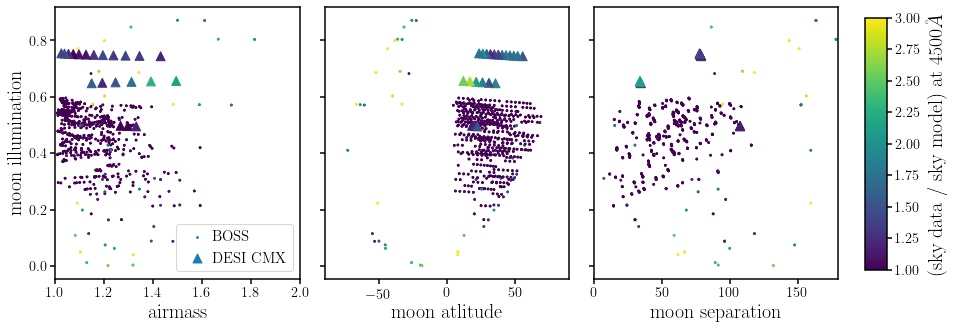

In [44]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c=boss_4500/modelv2_boss_4500, s=3, vmin=1., vmax=3., label='BOSS')
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], marker='^', c=desi_4500/modelv2_desi_4500, s=80, vmin=1., vmax=3., label='DESI CMX')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c=boss_4500/modelv2_boss_4500, s=3, vmin=1., vmax=3.)
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], marker='^', s=80, c=desi_4500/model_desi_4500, vmin=1., vmax=3.)
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sct = sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c=boss_4500/modelv2_boss_4500, s=3, vmin=1., vmax=3.)
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], marker='^', c=desi_4500/modelv2_desi_4500, s=80, vmin=1., vmax=3.)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label(label='(sky data / sky model) at $4500\AA$', fontsize=20)

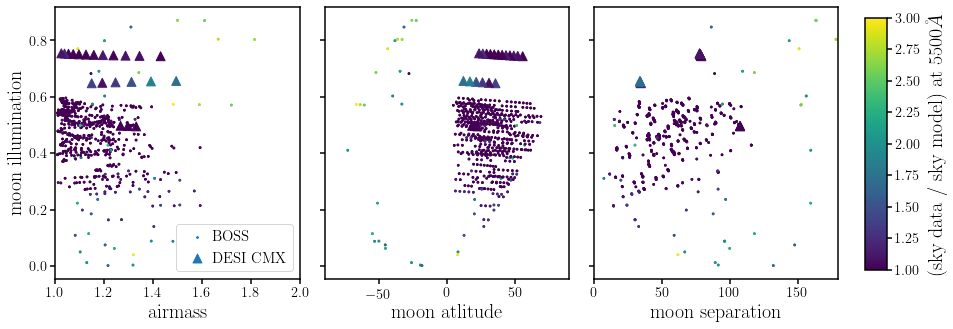

In [45]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c=boss_5500/modelv2_boss_5500, s=3, vmin=1., vmax=3., label='BOSS')
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], marker='^', c=desi_5500/modelv2_desi_5500, s=80, vmin=1., vmax=3., label='DESI CMX')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c=boss_5500/modelv2_boss_5500, s=3, vmin=1., vmax=3.)
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], marker='^', s=80, c=desi_5500/modelv2_desi_5500, vmin=1., vmax=3.)
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sct = sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c=boss_5500/modelv2_boss_5500, s=3, vmin=1., vmax=3.)
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], marker='^', c=desi_5500/modelv2_desi_5500, s=80, vmin=1., vmax=3.)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label(label='(sky data / sky model) at $5500\AA$', fontsize=20)

It seems that the KS functional form dependence on moon separation and moon fraction is not very good...